
# Import Data

Importing AUDUSD data.

In [53]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forex_symbol = "USDCAD"

forex_df = pd.read_csv('../../data/gen/{}_Daily_df.csv'.format(forex_symbol),
                       parse_dates=True,
                       index_col=0)
# Strip whitespace from column names
forex_df.columns = forex_df.columns.str.strip()
# Print
forex_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change
,,,,,,,,
4998,2001-08-03,1.5364,1.5371,1.5292,1.5292,1.5292,0.000000,0.000000
4997,2001-08-06,1.5298,1.5304,1.5251,1.5251,1.5292,-0.002681,-26.811405
4996,2001-08-07,1.5252,1.5356,1.5230,1.5354,1.5251,0.006754,67.536555
4995,2001-08-08,1.5351,1.5358,1.5302,1.5343,1.5354,-0.000716,-7.164257
4994,2001-08-09,1.5342,1.5406,1.5322,1.5395,1.5343,0.003389,33.891677



## Performing Backtests

Assuming trading with Leverage

1. Analysing Parameters
1. Prepare Parameters
1. Dfine a DataFrame to handle results
1. For Loops
1. Prepare Maps & Filters

## Analysing Parameters

To determine sensible slop & velocity range to run backtests on, slope & velocity needs to be analysed.

### Calculate Slope & Velocity

In [54]:

extra_df = forex_df.copy()
extra_df['slope'] = pd.Series(np.gradient(extra_df.close), extra_df.index, name='slope')
extra_df['velocity'] = pd.Series(np.gradient(extra_df.slope), extra_df.index, name='velocity')
# Print
extra_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change,slope,velocity
,,,,,,,,,,
4998,2001-08-03,1.5364,1.5371,1.5292,1.5292,1.5292,0.000000,0.000000,-0.00410,0.007200
4997,2001-08-06,1.5298,1.5304,1.5251,1.5251,1.5292,-0.002681,-26.811405,0.00310,0.004350
4996,2001-08-07,1.5252,1.5356,1.5230,1.5354,1.5251,0.006754,67.536555,0.00460,-0.000525
4995,2001-08-08,1.5351,1.5358,1.5302,1.5343,1.5354,-0.000716,-7.164257,0.00205,-0.000550
4994,2001-08-09,1.5342,1.5406,1.5322,1.5395,1.5343,0.003389,33.891677,0.00350,-0.001650



### Analysing Slope & Velocity


DescribeResult(nobs=4999, minmax=(-0.036599999999999966, 0.03215000000000001), mean=-3.86577315463092e-05, variance=2.076668605309697e-05, skewness=-0.016370113005895533, kurtosis=5.1377492777963845)

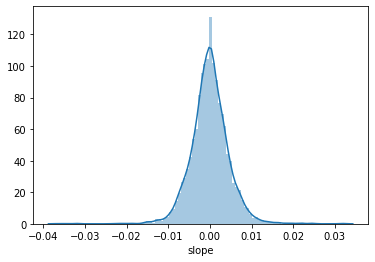

In [55]:

import seaborn as sns
from scipy import stats

sns.distplot(extra_df['slope'],
             bins=100,
             label="Daily Slope Change")
stats.describe(extra_df.slope)


DescribeResult(nobs=4999, minmax=(-0.032250000000000056, 0.027925000000000033), mean=1.7553510702141049e-06, variance=1.045952085269995e-05, skewness=-0.26610076340176486, kurtosis=6.244694831893957)

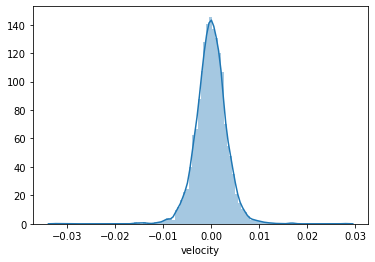

In [56]:

sns.distplot(extra_df['velocity'],
             bins=100,
             label="Daily Velocity Change")
stats.describe(extra_df.velocity)



## Preparing Parameters


In [57]:

import itertools

buy_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
buy_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
close_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
close_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
sell_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
sell_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)

task_list = list(itertools.product(
    buy_slope_threshold_list, 
    buy_velocity_threshold_list, 
    close_slope_threshold_list, 
    close_velocity_threshold_list, 
    sell_slope_threshold_list, 
    sell_velocity_threshold_list
))
print("Backtest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(task_list), round(len(task_list)/(375*60), 2)))


Backtest Params Ready, 15625 tasks to run. Will take about 0.69 minutes to complete.



## Maths for Forex Margin Trading

### Without Leverage: 

Equity required to trade a standard lot of AUDUSD would be **AUD$100,000** converted to USD.

Assuming **1 pip rise** in price, aka 0.01%, aka 0.0001 change in price, will result calculate as $100,000 * 0.01% profit. **Profit = AUD$10 - SWAPs**.

Or simply **1 pip = $10 of the base currency**

Therefore, Return is AUD$10 / AUD$100,000 = **0.01%** (Or simply, 1 pip). 

**Return Fomula without Leverage** is therefore:

> Return = 1 pip * 1 = 0.01% = 0.0001 (p_change * 1)

The 1 means 1:1 Leverage, or no leverage.

### With Leverage:

Let's assume the following:

Leverage: 400

Equity required to trade a standard lot of AUDUSD would be AUD$100,000 / 400, or **AUD$250** converted to USD.

Assuming **1 pip rise** in price, aka 0.01%, aka 0.0001 change in price, will result calculate as $100,000 * 0.01% profit. **Profit = AUD$10 - SWAPs**.

Or simply **1 pip = $10 of the base currency**

Therefore, **Return Fomula with Leverage** is AUD$10 / AUD$250 = **4%** (or simply, 400 pip).

**Return Fomula without Leverage** is therefore:

> Return = 1 pip * 400 = 4% = 0.04 (p_change * 400)

The 400 means 1:400 Leverage. 

## Backtesting with 1:400 Leverage


In [58]:

import concurrent.futures
from concurrent.futures.process import ProcessPoolExecutor
from datetime import datetime
from tqdm import tqdm

# Trading Parameters
lots = 1 
leverage = 400 # 400 Leverage
margin_interest = 0.1 # 10% Margin Interest
pip_cost = 0.8 # Transaction Cost 0.8 pip
stop_loss = 2.0 # Stop Loss at 2.0 of standard deviation (so 5%)
one_trade_week = 6 # 6 Trade days a week for Forex
one_trade_month = one_trade_week * 4
two_trade_month = one_trade_month * 2
three_trade_month = one_trade_month * 3
half_trade_year = three_trade_month * 2
one_trade_year = half_trade_year * 2


In [59]:

backtest_df = forex_df[:-one_trade_year] # We use all available data until 2 years ago
    
# Defining a DataFrame to handle results
backtest_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

def single_test(data_df, 
                t_lots,
                t_leverage,
                t_pip_cost,
                buy_slope_threshold, 
                buy_velocity_threshold, 
                close_slope_threshold, 
                close_velocity_threshold, 
                sell_slope_threshold, 
                sell_velocity_threshold):
            
        """
        Firstly, add `slope` and `velocity` columns to DataFrame
        """
        data_df['profit'] = 0
        data_df['slope'] = pd.Series(np.gradient(data_df.pre_close), data_df.index, name='slope') # Find the slope of yesterday, aka. pre_close
        data_df['velocity'] = pd.Series(np.gradient(data_df.slope), data_df.index, name='velocity')
        
        """
        Secondly, Closing
        """
        data_df['position'] = "CLOSE"
        
        """
        Thirdly, Buying
        """
        long_mask = (data_df.slope > buy_slope_threshold) & (data_df.velocity > buy_velocity_threshold)
        long_close = (data_df.slope < -close_slope_threshold) & (data_df.velocity < -close_velocity_threshold)
        data_df.loc[long_mask, 'position'] = "LONG"
        data_df.loc[long_mask, 'profit'] = (data_df.loc[long_mask, 'pip_change'] - t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
        
        """
        Finally, Selling
        """
        short_mask = (data_df.slope < sell_slope_threshold) & (data_df.velocity < sell_velocity_threshold)
        short_close = (data_df.slope > close_slope_threshold) & (data_df.velocity > close_velocity_threshold)
        data_df.loc[short_mask, 'position'] = "SHORT"
        data_df.loc[short_mask, 'profit'] = -(data_df.loc[short_mask, 'pip_change'] + t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
    
        test_result = [buy_slope_threshold, 
                       buy_velocity_threshold, 
                       close_slope_threshold, 
                       close_velocity_threshold, 
                       sell_slope_threshold, 
                       sell_velocity_threshold, 
                       data_df.profit.sum() / (lots * 100000 / t_leverage)]
        return test_result

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    backtest_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in task_list]
    print("Running {} tasks".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        backtest_result = backtest_result.append(pd.Series(result_row, index=backtest_result.columns), ignore_index=True)

    print("Finished {} tasks in {}".format(len(task_list), datetime.now() - start_time))


15.6ktests [01:40, 155tests/s]


Running 15625 tasks
Finished 15625 tasks in 0:01:41.373645



## Analysing Backtest Results


In [60]:
        
backtest_result = backtest_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
backtest_result.to_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))
backtest_result.head()


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
3545,-0.002773,-0.003232,0.000873,-0.001939,0.000873,0.001942,5495.095506
3269,-0.002773,-0.003232,-0.002773,-0.003232,0.000873,0.001942,5495.095506
3570,-0.002773,-0.003232,0.000873,-0.000645,0.000873,0.001942,5495.095506
3468,-0.002773,-0.003232,-0.000950,0.000649,0.000873,0.001942,5495.095506
3419,-0.002773,-0.003232,-0.000950,-0.001939,0.000873,0.001942,5495.095506


In [61]:

backtest_result = pd.read_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

paper_df = forex_df[-one_trade_year:] # We use all available data until 2 years ago
paper_params = backtest_result.iloc[:1000]

test_list = list(zip(paper_params.buy_slope_threshold, 
                    paper_params.buy_velocity_threshold,
                    paper_params.close_slope_threshold, 
                    paper_params.close_velocity_threshold,
                    paper_params.sell_slope_threshold, 
                    paper_params.sell_velocity_threshold,))

print("Params Ready, {} tasks to run. ".format(len(test_list)))
    

Params Ready, 1000 tasks to run. 


In [62]:
# Defining a DataFrame to handle results
paper_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    paper_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in test_list]
    print("Running {} tests".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        paper_result = paper_result.append(pd.Series(result_row, index=paper_result.columns), ignore_index=True)

    print("Finished {} tests in {}".format(len(test_list), datetime.now() - start_time))


1.00ktests [00:03, 259tests/s]


Running 1000 tests
Finished 1000 tests in 0:00:03.999805



## Analysing Forward Test Results


In [63]:
        
paper_result = paper_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
paper_result.to_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))
paper_result.head()


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
397,-0.002773,-0.001939,0.002696,-0.000645,-0.00095,0.001942,213.993079
385,-0.002773,-0.001939,-0.004596,-0.000645,-0.00095,0.001942,213.993079
398,-0.002773,-0.001939,-0.000950,-0.001939,-0.00095,0.001942,213.993079
375,-0.002773,-0.001939,-0.000950,-0.000645,-0.00095,0.001942,213.993079
376,-0.002773,-0.001939,-0.002773,-0.000645,-0.00095,0.001942,213.993079



## Plotting Best Params

Plot the best trading result.

Plotting 288 results for trade days
SHORT 2018-08-13 - 2018-08-15
LONG 2018-08-15 - 2018-08-16
CLOSE 2018-08-17
SHORT 2018-08-17 - 2018-08-20
LONG 2018-08-20 - 2018-08-22
SHORT 2018-08-22 - 2018-08-23
LONG 2018-08-23 - 2018-08-24
CLOSE 2018-08-25
SHORT 2018-08-25 - 2018-08-26
LONG 2018-08-26 - 2018-08-27
SHORT 2018-08-27 - 2018-08-29
LONG 2018-08-29 - 2018-09-05
CLOSE 2018-09-06
SHORT 2018-09-06 - 2018-09-07
LONG 2018-09-07 - 2018-09-10
CLOSE 2018-09-11
SHORT 2018-09-11 - 2018-09-13
CLOSE 2018-09-14
LONG 2018-09-14 - 2018-09-18
SHORT 2018-09-18 - 2018-09-20
CLOSE 2018-09-21
LONG 2018-09-21 - 2018-09-27
CLOSE 2018-09-28
SHORT 2018-09-28 - 2018-10-01
CLOSE 2018-10-02
LONG 2018-10-02 - 2018-10-05
CLOSE 2018-10-06
LONG 2018-10-06 - 2018-10-11
CLOSE 2018-10-12
SHORT 2018-10-12 - 2018-10-14
LONG 2018-10-14 - 2018-10-15
SHORT 2018-10-15 - 2018-10-17
LONG 2018-10-17 - 2018-10-19
CLOSE 2018-10-21
LONG 2018-10-21 - 2018-10-23
SHORT 2018-10-23 - 2018-10-25
LONG 2018-10-25 - 2018-11-01
SHORT 2018-

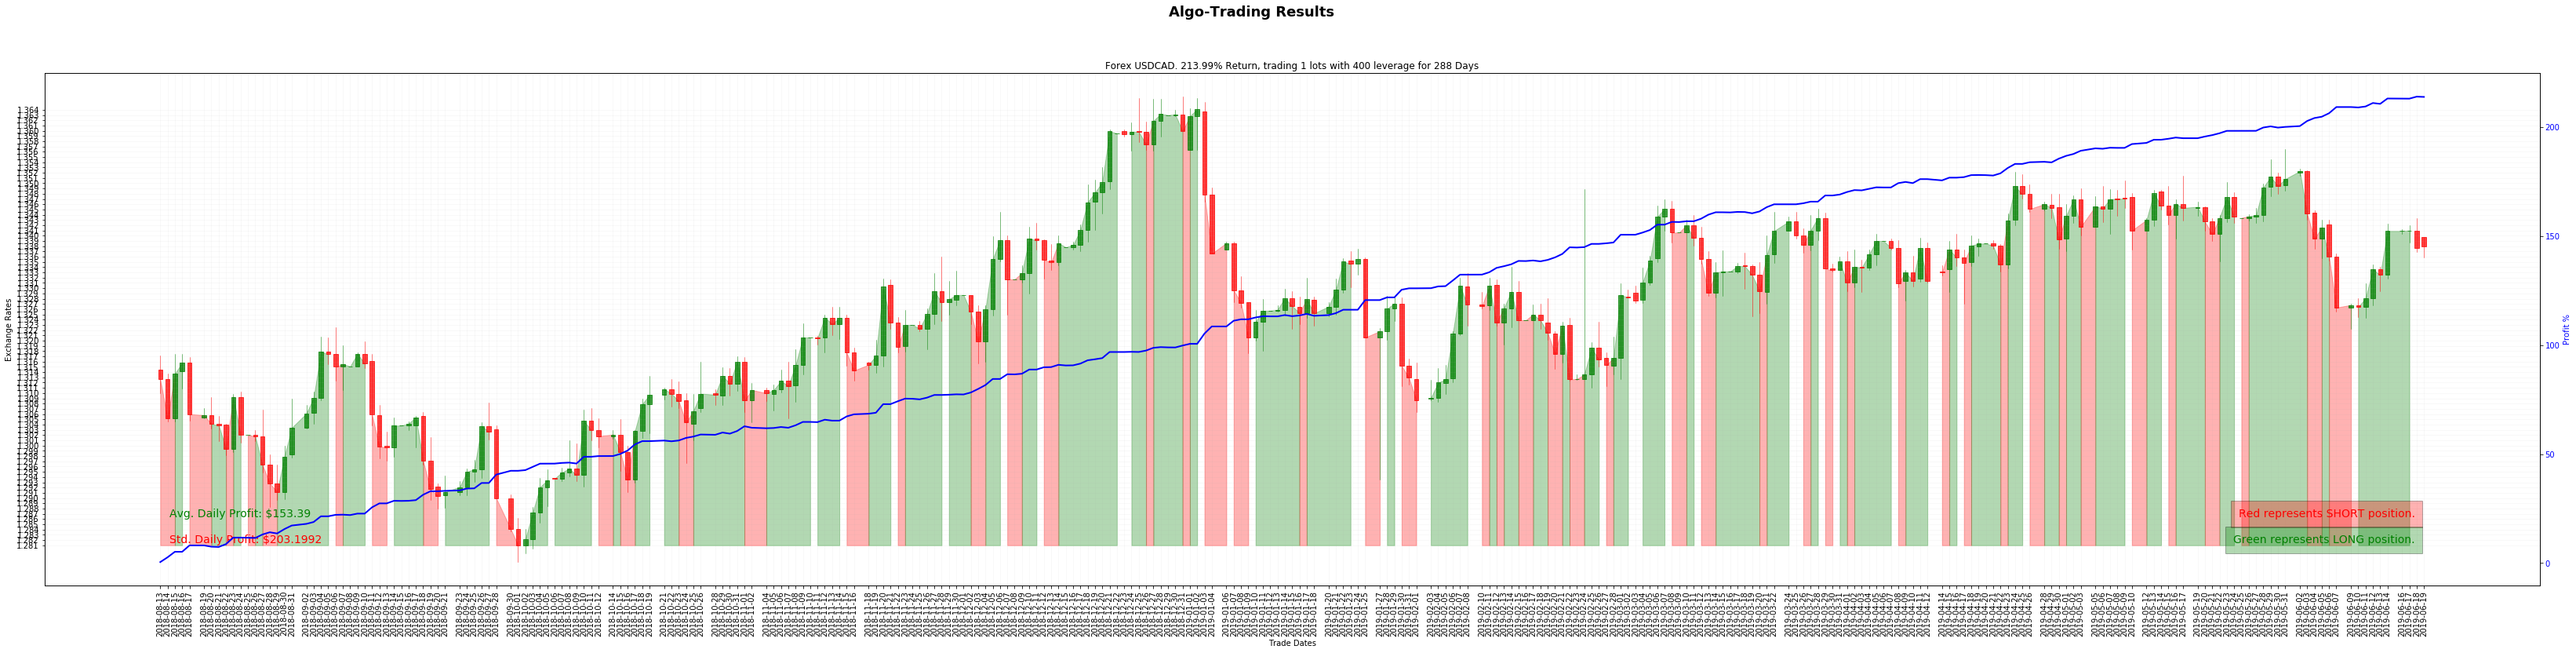

In [64]:

import import_ipynb
from strategy_sv import TradeStrategySV

paper_result = pd.read_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))

fig, axs = plt.subplots(figsize = (int(len(paper_df.index)/5),12))

fig.suptitle('Algo-Trading Results', fontsize=18, fontweight='bold')

best_strategy = TradeStrategySV(leverage=leverage,
                               margin=margin_interest,
                               pip_cost=pip_cost,
                               buy_slope_threshold=paper_result.buy_slope_threshold[1], 
                               buy_velocity_threshold=paper_result.buy_velocity_threshold[1], 
                               close_slope_threshold=paper_result.close_slope_threshold[1], 
                               close_velocity_threshold=paper_result.close_velocity_threshold[1], 
                               sell_slope_threshold=paper_result.sell_slope_threshold[1], 
                               sell_velocity_threshold=paper_result.sell_velocity_threshold[1], 
                               should_log=True)
forex_df = best_strategy.trade(data_df=paper_df, 
                              symbol=forex_symbol,
                              lots=lots,
                              stop_loss=stop_loss,)



best_strategy.plot_trade(axs=axs)

fig.savefig('../gen/StrategySV_{}_Daily.png'.format(forex_symbol), dpi=150, bbox_inches="tight")

print("In the latest {} trading days, StrategySV (Optimized) resulted ${}, or {}%".format(len(paper_df.index), round(best_strategy.trade_profit, 2), round(best_strategy.trade_profit/(lots * 100000 / leverage), 2)))
